# Project for exam *Applied Machine Learning - Basic*

**Daniele Massaro**, PhD student in Physics (36° cycle)  
*Alma Mater Studiorum - Università di Bologna*

---

# The MNIST project
The [MNIST](http://yann.lecun.com/exdb/mnist/) (Modified National Institute of Standards and Technology database) is a database of handwritten digits, widely used by the machine learning community to evaluate the capabilities of their algorithms.

> If it doesn't work on MNIST, it won't work at all.  
> Well, if it does work on MNIST, it may still fail on others.

>   -- *Unknown author*


It was developed by Yann LeCun, Corinna Cortes and Christopher Burges.  
The MNIST database contains 60000 training images and 10000 testing images, which were taken from various scanned documents.
They have been normalised to fit 28x28 pixel bounding box and centered.

Excellent results achieve a prediction error of less than 1%.
State-of-the-art prediction error of approximately 0.2% can be achieved with large Convolutional Neural Networks.

## Prepare the environment and load the dataset

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
import pandas as pd
import seaborn as sns
import sklearn
import os.path
from joblib import dump, load

##### matplotlib settings
from matplotlib.pyplot import rcParams, rcParamsDefault

##### pandas settings
from pandas import set_option

set_option('display.width', 200)
set_option('display.max_rows', 100)
set_option('display.max_columns', 50)
set_option('precision', 3)

##### numpy settings
from numpy import set_printoptions

set_printoptions(precision=3, linewidth=400)

##### pseudo-random number generator seed
seed = 7

Define also some useful paths.

In [2]:
plots_directory = "plots"
metrics_directory = "cv_metrics"
models_directory = "models"

The database is made of four different datasets:
* [`train-images-idx3-ubyte.gz`](http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz):  training set images (9912422 bytes);
* [`train-labels-idx1-ubyte.gz`](http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz):  training set labels (28881 bytes);
* [`t10k-images-idx3-ubyte.gz`](http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz):  test set images (1648877 bytes);
* [`t10k-labels-idx1-ubyte.gz`](http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz):  test set labels (4542 bytes).

The dataset is in binary format.
There exist a ready-to-use `.csv` version, made by Joseph Redmon and available [here](https://pjreddie.com/projects/mnist-in-csv/):
* [`mnist_train.csv`](https://pjreddie.com/media/files/mnist_train.csv);
* [`mnist_test.csv`](https://pjreddie.com/media/files/mnist_test.csv).

Each row consists of 785 values: the first one is the label (an integer from 0 to 9) and the others are the grey-scaled pixels of a 28x28 image (integers ranging from 0 to 255).

In [3]:
dataset_train = pd.read_csv(filepath_or_buffer="https://pjreddie.com/media/files/mnist_train.csv", sep=",", names=None, header=None)
dataset_test = pd.read_csv(filepath_or_buffer="https://pjreddie.com/media/files/mnist_test.csv", sep=",", names=None, header=None)
DIM_X, DIM_Y = 28, 28

**NOTE: We will use only $1/4$ of the data, in order to reduce the time of training and fine tuning.
Using more samples will likely improve the situation, but it is also time expensive for some models.**

In [4]:
dataset_train = dataset_train[:len(dataset_train)//4]
dataset_test = dataset_test[:len(dataset_test)//4]

### Let's draw some of these digits.

#### 12 random digits

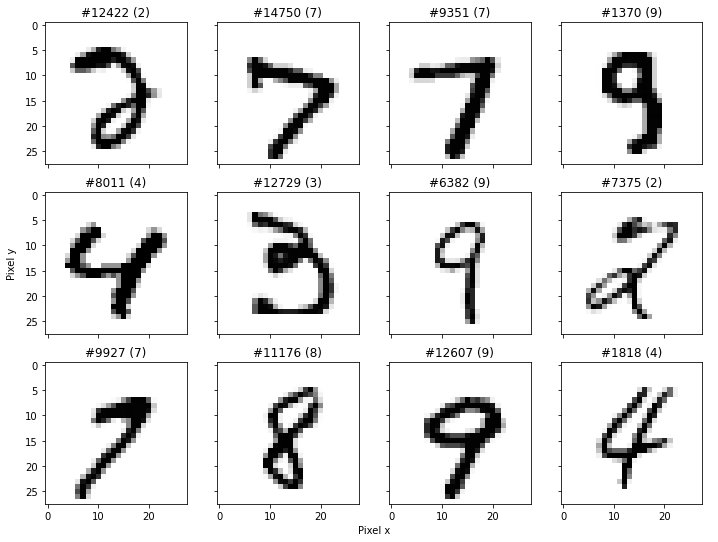

In [31]:
fig, axs = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(30/2.54,22.5/2.54))
axs[0,0].set_aspect("equal", share=True)
digits_indices = random.randint(0, len(dataset_train), size=axs.size, dtype=np.int)
for ax, i in zip(axs.flatten(), digits_indices):
    label = dataset_train.values[i,0]
    pixels = dataset_train.values[i,1:].reshape((DIM_X, DIM_Y))
    ax.set_title("#{:d} ({:d})".format(i, label))
    ax.imshow(pixels, cmap="Greys")
# Draw a big invisible axes to insert common axis labels
big_ax = fig.add_subplot(111, frameon=False)
big_ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
big_ax.set_xlabel("Pixel x")
big_ax.set_ylabel("Pixel y");

#### Digits from 0 to 9

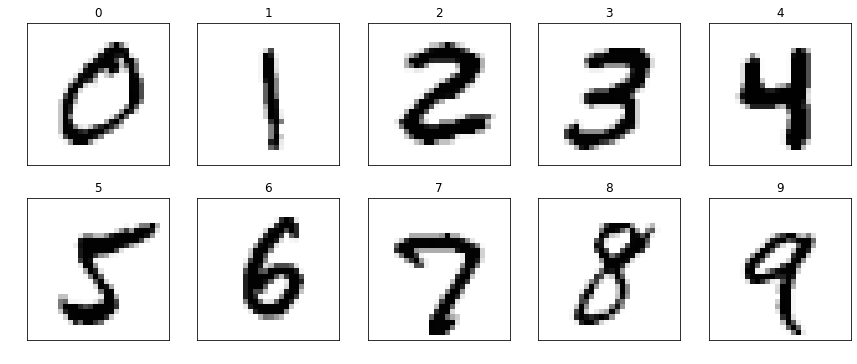

In [100]:
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(37.5/2.54,15/2.54))
axs[0,0].set_aspect("equal", share=True)
digits_indices = [1, 8, 25, 7, 58, 236, 62, 52, 85, 4]
for ax, i in zip(axs.flatten(), digits_indices):
    label = dataset_train.values[i,0]
    pixels = dataset_train.values[i,1:].reshape((DIM_X, DIM_Y))
    ax.set_title("{:d}".format(label))
    ax.imshow(pixels, cmap="Greys")
    ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# fig.tight_layout()
fig.savefig(os.path.join(plots_directory, "digits.jpg"), dpi=400)

## Explore dataset 1 - Numbers

In [34]:
dataset_train.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Study the shape and types

In [35]:
ds_train_shape = dataset_train.shape
ds_test_shape = dataset_test.shape
print("Training dataset shape:", ds_train_shape)
print("Test dataset shape:", ds_test_shape)

Training dataset shape: (15000, 785)
Test dataset shape: (2500, 785)


In [36]:
dataset_test.dtypes

0      int64
1      int64
2      int64
3      int64
4      int64
       ...  
780    int64
781    int64
782    int64
783    int64
784    int64
Length: 785, dtype: object

### See if there are corrupted values

In [37]:
print("Corrupted values:")
print("In training dataset: {}".format(np.sum(~np.isfinite(dataset_train.values))))
print("In test dataset: {}".format(np.sum(~np.isfinite(dataset_test.values))))

Corrupted values:
In training dataset: 0
In test dataset: 0


### See if we are in a case of skewed classes
Let's see if the dataset is homogeneous, namely we have about the same quantities of samples from each class.
In this case we group the datasets by the first index (the label) and we count how many of them appears.
As a cross check, the sum of the sizez should be equal to the number of the rows of the dataset.

In [38]:
sizes_train = dataset_train.groupby(by=0).size()
print("Average number of samples from each class: {:.2f} {:s} {:.2f}".format(sizes_train.mean(), u"\u00B1", sizes_train.std()))
print("Sum of sizes:", sizes_train.sum())

0
0    1496
1    1690
2    1462
3    1548
4    1468
5    1318
6    1490
7    1593
8    1432
9    1503
dtype: int64
Average number of samples from each class: 1500.00 ± 98.54
Sum of sizes: 15000


In [39]:
sizes_test = dataset_test.groupby(by=0).size()
print("Average number of samples from each class: {:.2f} {:s} {:.2f}".format(sizes_test.mean(), u"\u00B1", sizes_test.std()))
print("Sum of sizes:", sizes_test.sum())

0
0    219
1    287
2    276
3    254
4    275
5    221
6    225
7    257
8    242
9    244
dtype: int64
Average number of samples from each class: 250.00 ± 24.18
Sum of sizes: 2500


For both training and test datasets we have that the samples from each class are about the same (within a couple of standard deviation at most).  
We can consider the dataset to be homogeneous, so, in the following, the accuracy score will represent a robust performance measure.

## Explore dataset 2 - Visualisation
We can plot the distribution of the labels and see if they follow an uniform distribution.

In [41]:
def plot_hist_labels(dataset, title):
    fig, ax = plt.subplots()
    dataset_train[0].hist(ax=ax, bins=np.arange(-0.5, 10., 1))
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(np.arange(10))
    ax.set_xlabel("Label")
    ax.set_ylabel("Counts")
    ax.set_title(title)
    return fig, ax

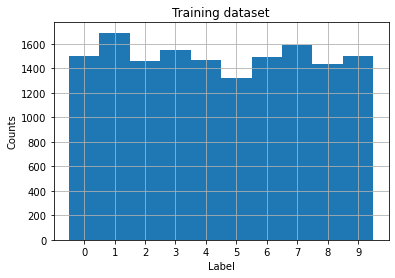

In [42]:
plot_hist_labels(dataset_train, title="Training dataset");

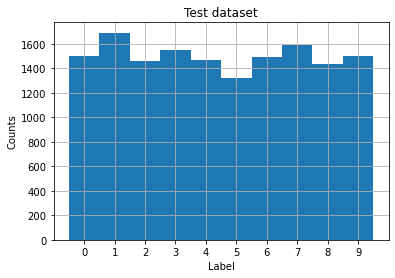

In [43]:
plot_hist_labels(dataset_train, title="Test dataset");

## Data preparation
We separate the datasets in `x` and `y`.
We normalise the `x` values in range $[0,1]$.
This is simple, as now the range is $[0,255]$.

### Standardise the dataset

In [5]:
x_train_original = dataset_train.values[:,1:] / 255.
y_train = dataset_train.values[:,0]
x_test_original = dataset_test.values[:,1:] / 255.
y_test = dataset_test.values[:,0]

### Feature selection
Given the fact that each training sample has 784 features (a 28x28 pixels matrix) we can use *principal component analysis* to transform the features and reduce the dimensionality of the problem.

In [6]:
from sklearn.decomposition import PCA

We will try to reduce the features to keep at least 90% of the total variance.

In [7]:
pca = PCA(n_components=400)
fit_pca = pca.fit(x_train_original)

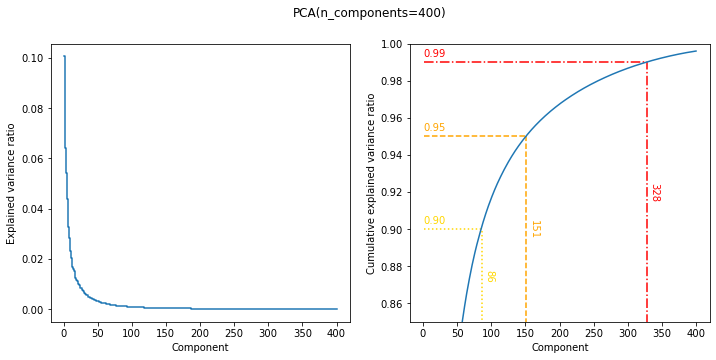

In [8]:
from scipy.interpolate import interp1d
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15*2/2.54, 13/2.54), sharex=True)
n_components = np.arange(1, fit_pca.n_components+1, 1)
axs[0].step(n_components, fit_pca.explained_variance_ratio_, where='mid')
fit_pca_cumulative = np.array([np.sum(fit_pca.explained_variance_ratio_[:n]) for n in n_components])
axs[1].plot(n_components, fit_pca_cumulative)
cumulative = interp1d(fit_pca_cumulative, n_components)
variances = [0.9, 0.95, 0.99]
n_comp_variances = list(map(lambda n: np.ceil(cumulative(n)).astype(np.int), variances))
colors_variances = ['gold', 'orange', 'red']
ls_variances = [':','--','-.']
for var, n_comp_var, c_var in zip(variances, n_comp_variances, colors_variances):
    axs[1].text(s="{:.2f}".format(var), x=0., y=var+0.002, c=c_var, ha='left', va='bottom')
    axs[1].text(s=n_comp_var, x=n_comp_var+4, y=(var+0.85)/2, c=c_var, rotation=-90, ha='left', va='center')
axs[1].hlines(y=variances, xmin=n_components[0], xmax=n_comp_variances, colors=colors_variances, linestyles=ls_variances)
axs[1].vlines(x=n_comp_variances, ymin=0., ymax=variances, colors=colors_variances, linestyles=ls_variances)
fig.suptitle("PCA(n_components={:d})".format(fit_pca.n_components))
axs[0].set_xlabel("Component")
axs[0].set_ylabel("Explained variance ratio")
axs[1].set_ylabel("Cumulative explained variance ratio")
axs[1].set_xlabel("Component")
axs[1].set_ylim((0.85, 1.));

We see that we need at least 86 features.

In [9]:
pca = PCA(n_components=90)
fit_pca = pca.fit(x_train_original)
x_train_pca = fit_pca.transform(x_train_original)
x_test_pca = fit_pca.transform(x_test_original)

In [10]:
ds_train_pca = pd.DataFrame(x_train_pca)
ds_test_pca = pd.DataFrame(x_test_pca)

In [11]:
print("Shape of new training dataset: " + str(ds_train_pca.shape))
print("Shape of new test dataset: " + str(ds_test_pca.shape))
print("Cumulative explained variance ratio: {:.3f}".format(np.sum(fit_pca.explained_variance_ratio_)))

Shape of new training dataset: (15000, 90)
Shape of new test dataset: (2500, 90)
Cumulative explained variance ratio: 0.906


### Normalize the new dataset
The new dataset coming out from principal component analysis is a brand new dataset.
So, we should normalise it appropriately.

In [12]:
ds_train_pca.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
0,0.407,-1.286,-0.154,-2.092,-0.210,-1.090,0.855,0.282,-1.609,-0.624,0.516,-1.292,-2.240,-1.879,0.379,0.263,-1.423,1.290,-1.342,0.360,0.061,0.203,0.928,9.832e-01,0.160,...,0.530,0.315,0.045,0.003,-0.148,-0.273,-0.726,-0.211,-0.019,-0.380,0.384,0.017,-0.101,0.279,0.053,-0.044,0.453,-0.108,0.274,-0.254,-0.133,0.365,0.183,0.023,0.193
1,4.034,-1.642,1.717,-1.230,-3.522,-0.666,-0.180,-0.448,0.230,-0.627,-1.311,-0.437,0.491,-1.272,-0.749,0.418,0.276,0.194,-0.076,-0.472,-0.815,0.042,0.164,5.753e-01,-0.727,...,-0.296,0.355,-0.384,-0.179,-0.121,0.035,-0.553,-0.151,0.468,-0.121,-0.113,0.296,0.030,0.245,0.011,0.176,-0.185,-0.305,-0.335,-0.190,0.025,0.005,0.074,0.106,-0.028
2,-0.247,1.673,-1.126,1.876,-1.076,0.503,-3.406,1.450,-0.565,0.915,1.576,-0.998,-0.416,0.171,-0.661,0.756,-0.456,-0.479,0.547,-1.722,0.068,-0.062,-0.400,-9.426e-02,0.335,...,-0.562,0.807,-0.478,0.514,-0.654,-0.025,-0.023,-0.089,-0.139,0.056,-0.221,-0.374,0.436,0.025,0.637,-0.788,0.646,-0.071,-0.349,0.435,-0.051,0.117,0.265,-0.246,-0.179
3,-3.401,-2.351,0.928,0.490,-0.124,2.741,-1.359,-0.168,1.408,0.166,-1.691,-0.390,-0.979,0.458,-0.886,-0.077,0.042,0.780,-0.594,0.245,0.349,-0.631,0.101,4.926e-04,-0.521,...,-0.143,0.310,-0.232,-0.156,0.290,0.140,0.275,0.152,0.073,-0.055,0.022,-0.190,-0.032,0.083,0.107,0.021,-0.343,-0.079,-0.269,0.040,-0.078,-0.158,0.136,0.010,0.001
4,-1.332,2.853,0.447,-0.979,0.358,0.001,-0.490,-1.313,1.163,-0.823,-1.264,1.837,1.656,-0.290,0.602,0.982,0.082,-0.558,-0.010,-1.006,-0.146,-0.363,-0.713,4.039e-02,-0.300,...,0.207,0.256,0.337,-0.335,-0.375,0.419,0.158,-0.006,0.294,-0.145,-0.097,-0.159,-0.033,-0.178,0.388,0.156,0.176,0.179,-0.469,-0.167,-0.075,-0.131,0.439,-0.148,0.223
5,0.808,0.524,2.286,0.564,1.154,1.098,0.012,0.449,-0.395,-0.404,0.012,-1.404,0.739,-0.702,2.230,1.616,-0.441,-0.266,0.894,-0.376,0.296,0.943,-0.502,-1.819e+00,0.002,...,-0.061,0.321,-0.047,0.096,0.185,0.320,0.210,0.306,0.605,0.325,0.185,0.215,0.126,-0.115,0.178,-0.237,-0.236,0.405,0.098,0.234,-0.261,-0.142,0.157,0.151,-0.276
6,-2.844,-0.296,-1.162,0.186,-0.526,-2.044,1.060,-0.491,-0.819,-2.007,1.419,1.272,-0.405,0.945,0.359,0.210,1.590,-0.860,0.027,-1.033,-0.363,-0.323,-0.465,4.873e-01,-0.072,...,-0.144,0.023,0.246,0.555,-0.116,-0.060,-0.132,0.071,0.046,0.060,0.218,0.391,0.246,0.142,0.198,-0.123,0.104,-0.072,0.104,0.181,0.159,-0.083,-0.076,-0.202,0.291
7,1.901,-1.527,-0.005,-3.573,2.766,1.233,-2.129,0.561,-1.929,-0.258,1.041,0.165,-0.775,-1.171,-0.391,0.984,-0.832,0.739,-0.176,-1.438,-0.526,-0.180,-0.572,8.057e-01,0.435,...,0.038,0.138,-0.277,-0.069,-0.059,-0.270,-0.310,0.452,0.390,-0.032,-0.059,0.004,-0.244,-0.274,0.062,0.481,0.224,-0.348,-0.345,0.288,0.020,0.192,0.111,-0.387,0.095
8,-3.402,0.005,-0.723,0.290,-1.985,-1.526,0.239,-0.778,-0.770,-1.216,1.592,0.667,0.469,0.706,0.142,0.831,0.861,-0.286,0.265,-0.040,0.055,-0.351,-0.619,1.074e-02,-0.265,...,-0.339,0.122,-0.218,-0.024,-0.337,-0.214,-0.146,0.426,0.062,0.084,-0.319,0.395,-0.251,0.214,0.402,0.130,0.052,-0.047,-0.112,0.284,0.003,0.146,-0.064,0.121,-0.015
9,-0.970,1.738,2.759,0.781,-0.057,-0.149,-1.851,0.113,-0.318,1.961,1.850,-0.019,0.201,0.231,0.686,-1.019,0.040,-0.774,-0.182,-0.829,0.463,0.481,0.673,1.269e+00,-0.125,...,-0.096,-0.343,-0.599,0.120,-0.145,0.154,0.104,-0.286,-0.071,-0.444,-0.368,-0.436,0.424,0.467,0.483,-0.162,0.439,-0.107,0.126,0.206,0.047,-0.006,-0.167,-0.466,0.143


In [13]:
ds_train_pca.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
count,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,...,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04,1.500e+04
mean,-4.225e-16,-1.135e-15,3.183e-16,-5.571e-16,3.032e-16,8.839e-16,-2.918e-16,-1.838e-16,-5.760e-16,2.582e-16,1.402e-16,1.630e-16,-3.070e-16,-9.379e-17,3.278e-16,-5.305e-17,-1.828e-16,2.681e-16,2.596e-16,1.270e-16,9.474e-19,-3.103e-17,-4.926e-17,3.126e-17,2.179e-17,...,-4.595e-17,9.119e-18,1.293e-16,-5.803e-17,-1.995e-17,1.007e-17,-2.487e-18,9.805e-17,-7.461e-18,6.395e-17,-7.176e-17,-5.134e-17,-7.046e-17,-7.094e-17,-8.882e-18,-8.242e-17,9.332e-17,5.258e-17,1.054e-17,8.005e-17,1.087e-16,-4.500e-17,4.855e-17,4.086e-17,-5.643e-17
std,2.314e+00,1.954e+00,1.850e+00,1.701e+00,1.589e+00,1.528e+00,1.322e+00,1.249e+00,1.230e+00,1.110e+00,1.058e+00,1.046e+00,9.510e-01,9.416e-01,9.205e-01,9.022e-01,8.282e-01,8.156e-01,7.920e-01,7.729e-01,7.436e-01,7.322e-01,7.103e-01,6.972e-01,6.775e-01,...,3.298e-01,3.258e-01,3.200e-01,3.181e-01,3.157e-01,3.111e-01,3.059e-01,3.009e-01,3.001e-01,2.915e-01,2.910e-01,2.883e-01,2.813e-01,2.749e-01,2.726e-01,2.706e-01,2.694e-01,2.673e-01,2.640e-01,2.634e-01,2.594e-01,2.565e-01,2.533e-01,2.509e-01,2.477e-01
min,-4.194e+00,-5.370e+00,-5.579e+00,-5.021e+00,-4.832e+00,-4.821e+00,-3.918e+00,-4.160e+00,-4.373e+00,-3.686e+00,-2.928e+00,-3.403e+00,-3.094e+00,-3.339e+00,-3.283e+00,-3.743e+00,-3.481e+00,-3.553e+00,-3.217e+00,-2.830e+00,-2.826e+00,-2.923e+00,-2.771e+00,-2.916e+00,-2.771e+00,...,-1.249e+00,-1.293e+00,-1.505e+00,-1.274e+00,-1.332e+00,-1.415e+00,-1.402e+00,-1.311e+00,-1.307e+00,-1.165e+00,-1.238e+00,-1.329e+00,-1.288e+00,-1.116e+00,-1.079e+00,-1.273e+00,-1.045e+00,-1.101e+00,-1.112e+00,-1.078e+00,-1.062e+00,-1.110e+00,-1.008e+00,-1.251e+00,-1.017e+00
25%,-1.600e+00,-1.470e+00,-1.325e+00,-1.249e+00,-1.045e+00,-1.034e+00,-9.560e-01,-8.376e-01,-8.376e-01,-7.739e-01,-7.690e-01,-7.065e-01,-6.605e-01,-6.650e-01,-6.449e-01,-5.714e-01,-5.233e-01,-5.427e-01,-5.239e-01,-5.147e-01,-4.759e-01,-4.735e-01,-4.717e-01,-4.299e-01,-4.486e-01,...,-2.125e-01,-2.024e-01,-1.896e-01,-2.070e-01,-2.061e-01,-1.970e-01,-1.916e-01,-1.966e-01,-1.914e-01,-1.854e-01,-1.867e-01,-1.810e-01,-1.815e-01,-1.769e-01,-1.760e-01,-1.761e-01,-1.760e-01,-1.704e-01,-1.715e-01,-1.692e-01,-1.664e-01,-1.615e-01,-1.630e-01,-1.584e-01,-1.596e-01
50%,-1.972e-01,-3.368e-01,3.352e-02,-5.482e-02,5.511e-02,3.889e-02,-6.446e-02,-5.096e-02,-5.375e-02,-3.096e-02,-5.982e-02,-1.346e-02,-2.960e-02,-4.955e-02,-1.931e-03,1.388e-02,4.978e-02,-2.426e-02,1.966e-02,-2.234e-02,1.733e-02,-1.034e-02,-2.134e-02,-2.861e-03,-9.360e-03,...,-5.286e-03,-4.757e-03,-9.842e-04,-5.169e-03,-2.291e-04,1.363e-03,-9.574e-04,-9.581e-04,3.928e-03,2.162e-03,-2.653e-03,1.832e-03,-5.029e-03,1.971e-03,1.074e-03,-3.145e-03,-6.250e-03,-3.055e-03,-2.577e-03,-5.421e-04,4.139e-04,-1.703e-03,6.716e-04,1.896e-03,1.147e-03
75%,1.346e+00,1.590e+00,1.373e+00,1.071e+00,1.084e+00,1.076e+00,8.831e-01,8.125e-01,8.343e-01,7.085e-01,7.155e-01,6.955e-01,6.073e-01,6.246e-01,6.298e-01,6.008e-01,5.495e-01,5.235e-01,5.315e-01,5.045e-01,4.830e-01,4.573e-01,4.573e-01,4.269e-01,4.472e-01,...,2.086e-01,1.970e-01,1.960e-01,2.042e-01,2.040e-01,2.002e-01,1.931e-01,1.958e-01,1.940e-01,1.839e-01,1.879e-01,1.893e-01,1.746e-01,1.806e-01,1.711e-01,1.731e-01,1.684e-01,1.732e-01,1.678e-01,1.708e-01,1.615e-01,1.630e-01,1.637e-01,1.581e-01,1.626e-01
max,9.206e+00,5.611e+00,5.945e+00,5.756e+00,5.355e+00,4.872e+00,4.871e+00,4.364e+00,5.062e+00,3.797e+00,4.232e+00,4.307e+00,3.372e+00,3.52

In [14]:
from sklearn.preprocessing import normalize

In [15]:
x_train = normalize(x_train_pca)
x_test = normalize(x_test_pca)

## Resampling
We will use a $10$-fold cross validation to split up the training dataset.

In [16]:
from sklearn.model_selection import KFold
num_folds = 10

## Models comparison
This problem is an example of multiclass classification.
The classes are the integer numbers from 0 to 9.
Each hand-written digit is associated to one of them.  
We will try the following models:
* Logistic Regression (LR);
* Linear Discriminant Analysis (LDA);
* $k$-Nearest Neighbors (KNN);
* Classification and Regression Trees (CART);
* Naive Bayes (NB);
* Linear Support Vector Machines (LSVM);
* Random Forest Classifier (RFC).

For some of them we need to use the wrapper [`sklearn.multiclass.OneVsRestClassifier`](https://scikit-learn.org/stable/modules/multiclass.html#onevsrestclassifier), to support the multiclass classification.
Moreover, we need to wrap `LinearSVC` inside [`sklearn.calibration.CalibratedClassifierCV`](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html).

In [17]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

Define the models. **Set the number of cores explicitly, otherwise it could result into an unexpected crash if too high**.

In [18]:
models = {}
models['LR']   = LogisticRegression(multi_class="ovr", max_iter=500)
models['LDA']  = OneVsRestClassifier(LinearDiscriminantAnalysis(), n_jobs=2)
models['KNN']  = OneVsRestClassifier(KNeighborsClassifier(), n_jobs=8)
models['CART'] = DecisionTreeClassifier()
models['NB']   = GaussianNB()
models['LSVM'] = CalibratedClassifierCV(LinearSVC(multi_class='ovr'), n_jobs=8)
models['RFC']  = RandomForestClassifier()

Before going into training, we will plot some learning curves to understand the performances of the various models on the basis of the number of training samples.
This was inspired by [this code snippet](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#plotting-learning-curves).

In [98]:
from sklearn.model_selection import learning_curve
def plot_learning_curves(model, title, x_train, y_train, cv, train_sizes, n_jobs, scoring='accuracy'):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(45/2.54, 15/2.54))
    fig.suptitle(title)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(model, x_train, y_train, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring, return_times=True, random_state=seed)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    fit_times_mean    = np.mean(fit_times, axis=1)
    fit_times_std     = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[0].legend(loc="best")
    axes[0].set_title("Learning curves")
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score: " + scoring)

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_title("Scalability of the model")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("Fit times")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_title("Performance of the model")
    axes[2].set_xlabel("Fit times")
    axes[2].set_ylabel("Score: " + scoring)

    return fig, axes

### Metrics computation
We will compute the following scores, assuming a one-vs-rest test:
* accuracy (`'accuracy'`);
* weighted Area Under ROC Curve (AUC, `'roc_auc_ovr_weighted'`);
* weighted F1-score (`'f1_weighted'`).

We will also plot the different confusion matrices for each model.

In [99]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix
scorings = ['accuracy', 'roc_auc_ovr_weighted', 'f1_weighted']

Define an helper function.

In [100]:
def save_metrics(name, accuracy, auc, f1_score, confusion_matrix, directory):
    np.savez(
            file=os.path.join(directory, "{}".format(name)),
            name=np.array(name, dtype=np.str),
            accuracy=accuracy.astype(np.float),
            auc=auc.astype(np.float),
            f1_score=f1_score.astype(np.float),
            confusion_matrix=confusion_matrix.astype(np.int)
        )

#### Logistic Regression

In [118]:
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

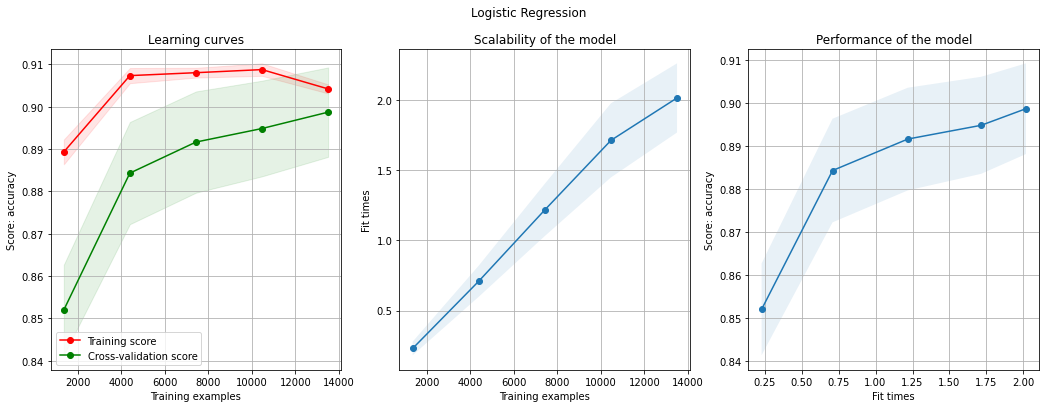

In [119]:
fig, ax = plot_learning_curves(
    model=models['LR'], 
    title="Logistic Regression", 
    x_train=x_train, 
    y_train=y_train, 
    cv=kfold, 
    train_sizes=np.linspace(0.1, 1., 5), 
    n_jobs=8
)
fig.savefig(os.path.join(plots_directory, "{}_learning_curves.pdf".format('LR')))

The training and cross-validation accuracy are approaching each other the more the training samples.
So, even increasing training examples, the situation will not improve much.
Fit times will increase, but we will not obtain huge improvement on accuracy.

In [120]:
%%time
name = 'LR'
output = cross_validate(models[name], x_train, y_train, cv=kfold, scoring=scorings, n_jobs=8, error_score='raise')
y_predicted = cross_val_predict(models[name], x_train, y_train, cv=kfold, n_jobs=8)
save_metrics(
    name=name, 
    accuracy=output['test_accuracy'], 
    auc=output['test_roc_auc_ovr_weighted'], 
    f1_score=output['test_f1_weighted'], 
    confusion_matrix=confusion_matrix(y_train, y_predicted), 
    directory=metrics_directory
)

CPU times: user 94.3 ms, sys: 20.1 ms, total: 114 ms
Wall time: 8.79 s


#### Linear Discriminant Analysis

In [115]:
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

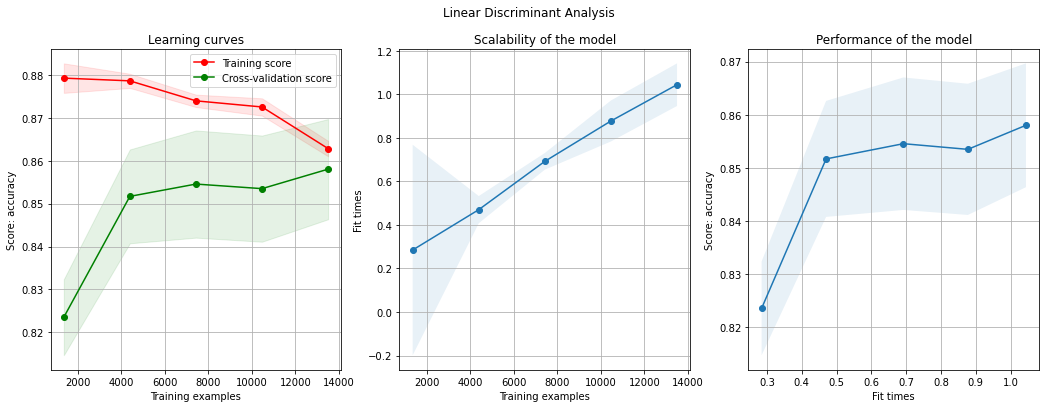

In [116]:
fig, ax = plot_learning_curves(
    model=models['LDA'], 
    title="Linear Discriminant Analysis", 
    x_train=x_train, 
    y_train=y_train, 
    cv=kfold, 
    train_sizes=np.linspace(0.1, 1., 5), 
    n_jobs=1
)
fig.savefig(os.path.join(plots_directory, "{}_learning_curves.pdf".format('LDA')))

The training and cross-validation accuracy are approaching each other the more the training samples.
So, even increasing training examples, the situation will not improve much.
Fit times will increase, but we will not obtain huge improvement on accuracy.

In [117]:
%%time
name = 'LDA'
output = cross_validate(models[name], x_train, y_train, cv=kfold, scoring=scorings, n_jobs=1, error_score='raise')
y_predicted = cross_val_predict(models[name], x_train, y_train, cv=kfold, n_jobs=1)
save_metrics(
    name=name, 
    accuracy=output['test_accuracy'], 
    auc=output['test_roc_auc_ovr_weighted'], 
    f1_score=output['test_f1_weighted'], 
    confusion_matrix=confusion_matrix(y_train, y_predicted), 
    directory=metrics_directory
)

CPU times: user 698 ms, sys: 101 ms, total: 799 ms
Wall time: 22.9 s


#### $k$-Nearest Neighbour

In [121]:
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

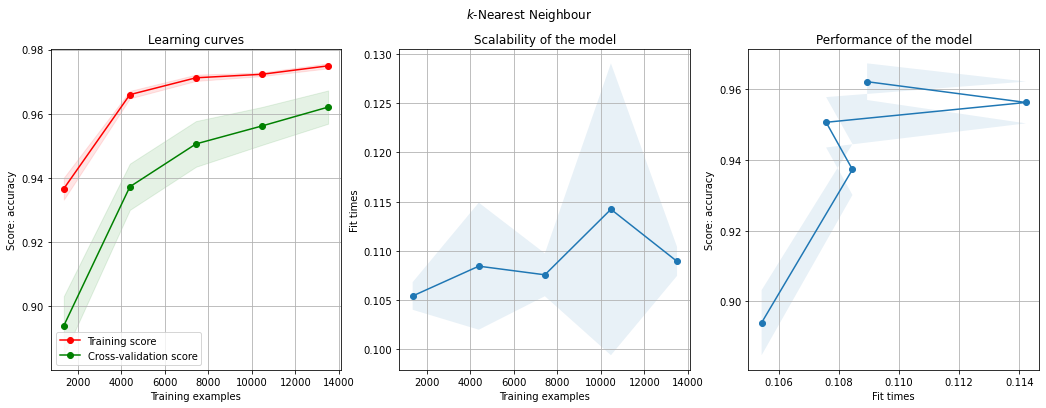

In [122]:
fig, ax = plot_learning_curves(
    model=models['KNN'], 
    title="$k$-Nearest Neighbour", 
    x_train=x_train, 
    y_train=y_train, 
    cv=kfold, 
    train_sizes=np.linspace(0.1, 1., 5), 
    n_jobs=2
)
fig.savefig(os.path.join(plots_directory, "{}_learning_curves.pdf".format('KNN')))

The cross-validation score seems to increase with the number of training examples, so, probably, a larger number of them could improve the accuracy.

In [123]:
%%time
name = 'KNN'
output = cross_validate(models[name], x_train, y_train, cv=kfold, scoring=scorings, n_jobs=4, error_score='raise')
y_predicted = cross_val_predict(models[name], x_train, y_train, cv=kfold, n_jobs=4)
save_metrics(
    name=name, 
    accuracy=output['test_accuracy'], 
    auc=output['test_roc_auc_ovr_weighted'], 
    f1_score=output['test_f1_weighted'], 
    confusion_matrix=confusion_matrix(y_train, y_predicted), 
    directory=metrics_directory
)

CPU times: user 130 ms, sys: 80 ms, total: 210 ms
Wall time: 1min 2s


#### Classification and Regression Trees

In [112]:
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

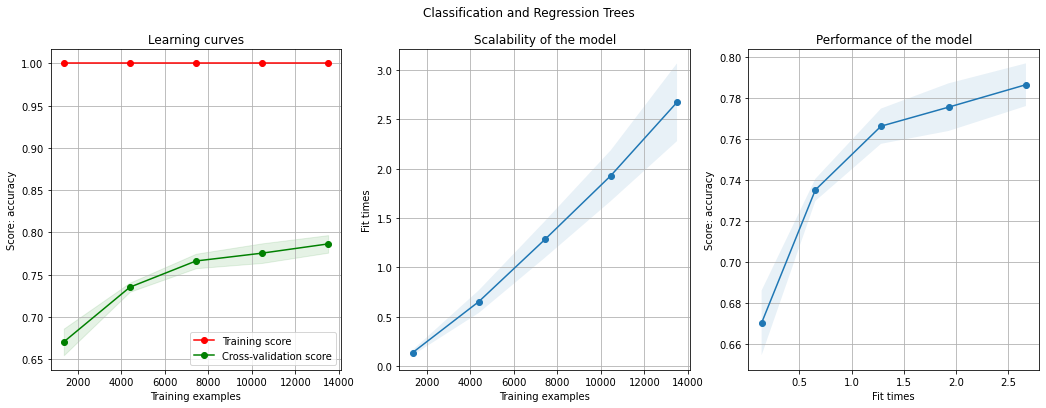

In [113]:
fig, ax = plot_learning_curves(
    model=models['CART'], 
    title="Classification and Regression Trees", 
    x_train=x_train, 
    y_train=y_train, 
    cv=kfold, 
    train_sizes=np.linspace(0.1, 1., 5), 
    n_jobs=8
)
fig.savefig(os.path.join(plots_directory, "{}_learning_curves.pdf".format('CART')))

Training score remains basically constant, while cross-validation score increases: we are in a high-variance case.
Increasing the training examples would improve the situation.

In [114]:
%%time
name = 'CART'
output = cross_validate(models[name], x_train, y_train, cv=kfold, scoring=scorings, n_jobs=8, error_score='raise')
y_predicted = cross_val_predict(models[name], x_train, y_train, cv=kfold, n_jobs=8)
save_metrics(
    name=name, 
    accuracy=output['test_accuracy'], 
    auc=output['test_roc_auc_ovr_weighted'], 
    f1_score=output['test_f1_weighted'], 
    confusion_matrix=confusion_matrix(y_train, y_predicted), 
    directory=metrics_directory
)

CPU times: user 95.6 ms, sys: 23.9 ms, total: 119 ms
Wall time: 8.94 s


#### Naive Bayes

In [109]:
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

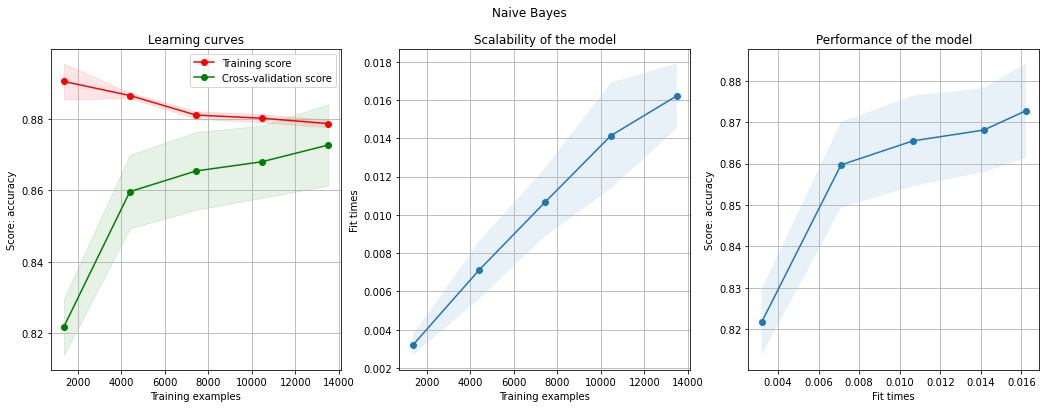

In [110]:
fig, ax = plot_learning_curves(
    model=models['NB'], 
    title="Naive Bayes", 
    x_train=x_train, 
    y_train=y_train, 
    cv=kfold, 
    train_sizes=np.linspace(0.1, 1., 5), 
    n_jobs=1
)
fig.savefig(os.path.join(plots_directory, "{}_learning_curves.pdf".format('NB')))

The training and cross-validation accuracy are approaching each other the more the training samples.
So, even increasing training examples, the situation will not improve much.
Fit times will increase, but we will not obtain huge improvement on accuracy.

In [111]:
%%time
name = 'NB'
output = cross_validate(models[name], x_train, y_train, cv=kfold, scoring=scorings, n_jobs=1, error_score='raise')
y_predicted = cross_val_predict(models[name], x_train, y_train, cv=kfold, n_jobs=1)
save_metrics(
    name=name, 
    accuracy=output['test_accuracy'], 
    auc=output['test_roc_auc_ovr_weighted'], 
    f1_score=output['test_f1_weighted'], 
    confusion_matrix=confusion_matrix(y_train, y_predicted), 
    directory=metrics_directory
)

CPU times: user 753 ms, sys: 0 ns, total: 753 ms
Wall time: 754 ms


#### Linear Support Vector Machines

In [106]:
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

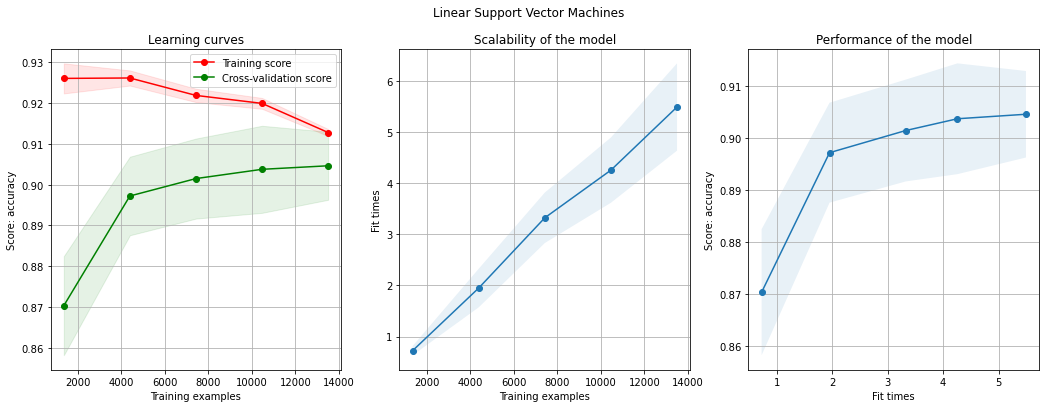

In [107]:
fig, ax = plot_learning_curves(
    model=models['LSVM'], 
    title="Linear Support Vector Machines", 
    x_train=x_train, 
    y_train=y_train, 
    cv=kfold, 
    train_sizes=np.linspace(0.1, 1., 5), 
    n_jobs=8
)
fig.savefig(os.path.join(plots_directory, "{}_learning_curves.pdf".format('LSVM')))

The training and cross-validation accuracy are approaching each other the more the training samples.
So, even increasing training examples, the situation will not improve much.
Fit times will increase, but we will not obtain huge improvement on accuracy.

In [108]:
%%time
name = 'LSVM'
output = cross_validate(models[name], x_train, y_train, cv=kfold, scoring=scorings, n_jobs=8, error_score='raise')
y_predicted = cross_val_predict(models[name], x_train, y_train, cv=kfold, n_jobs=8)
save_metrics(
    name=name, 
    accuracy=output['test_accuracy'], 
    auc=output['test_roc_auc_ovr_weighted'], 
    f1_score=output['test_f1_weighted'], 
    confusion_matrix=confusion_matrix(y_train, y_predicted), 
    directory=metrics_directory
)

CPU times: user 105 ms, sys: 8.22 ms, total: 113 ms
Wall time: 17.5 s


#### Random Forest Classifier

In [101]:
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

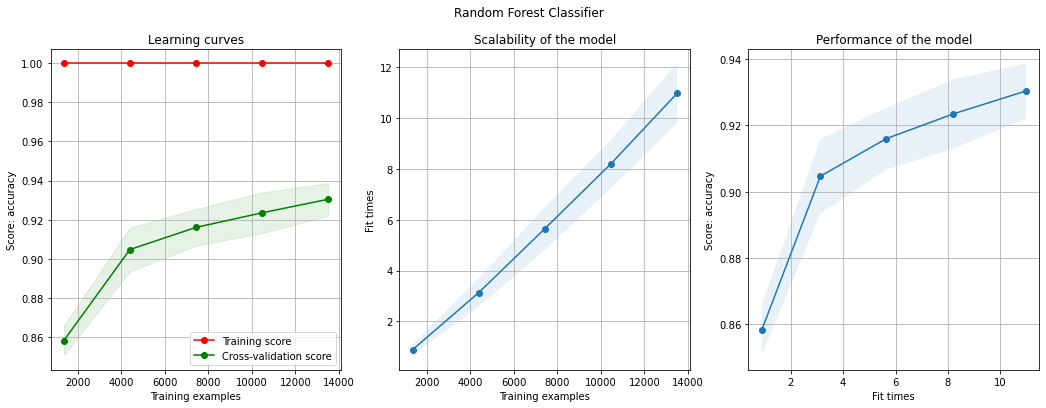

In [102]:
fig, ax = plot_learning_curves(
    model=models['RFC'], 
    title="Random Forest Classifier", 
    x_train=x_train, 
    y_train=y_train, 
    cv=kfold, 
    train_sizes=np.linspace(0.1, 1., 5), 
    n_jobs=8
)
fig.savefig(os.path.join(plots_directory, "{}_learning_curves.pdf".format('RFC')))

Training score remains basically constant, while cross-validation score increases: we are in a high-variance case.
Increasing the training examples would improve the situation.

In [103]:
%%time
name = 'RFC'
output = cross_validate(models[name], x_train, y_train, cv=kfold, scoring=scorings, n_jobs=8, error_score='raise')
y_predicted = cross_val_predict(models[name], x_train, y_train, cv=kfold, n_jobs=8)
save_metrics(
    name=name, 
    accuracy=output['test_accuracy'], 
    auc=output['test_roc_auc_ovr_weighted'], 
    f1_score=output['test_f1_weighted'], 
    confusion_matrix=confusion_matrix(y_train, y_predicted), 
    directory=metrics_directory
)

CPU times: user 94.7 ms, sys: 20.2 ms, total: 115 ms
Wall time: 42.2 s


### Metrics comparison
Read the saved files.

In [101]:
len_models = len(models)
names = np.array([], dtype=np.str)
accuracies = np.empty((len_models, num_folds))
aucs = np.empty((len_models, num_folds))
f1_scores = np.empty((len_models, num_folds))
confusion_matrices = []
for i, name in enumerate(models.keys()):
    file = np.load(os.path.join(metrics_directory, "{}.npz".format(name)))
    names = np.append(names, file['name'])
    accuracies[i] = file['accuracy']
    aucs[i] = file['auc']
    f1_scores[i] = file['f1_score']
    confusion_matrices.append(file['confusion_matrix'])

Let's inspect the metrics.

In [102]:
format_metric = lambda metric: "{:.5f} {:s} {:.5f}".format(metric.mean(), u"\u00B1", metric.std())
model_metrics = {
    'Accuracy': dict(zip(names, list(map(format_metric, accuracies)))),
    'Weighted AUC': dict(zip(names, list(map(format_metric, aucs)))),
    'Weighted F1-score': dict(zip(names, list(map(format_metric, f1_scores)))),
}
pd.DataFrame(model_metrics)

,Accuracy,Weighted AUC,Weighted F1-score
LR,0.89873 ± 0.01056,0.98753 ± 0.00217,0.89803 ± 0.01072
LDA,0.85800 ± 0.01166,0.97812 ± 0.00315,0.85709 ± 0.01206
KNN,0.96207 ± 0.00518,0.99390 ± 0.00086,0.96198 ± 0.00524
CART,0.78593 ± 0.01168,0.88122 ± 0.00652,0.78528 ± 0.01175
NB,0.87273 ± 0.01142,0.98845 ± 0.00140,0.87389 ± 0.01151
LSVM,0.90460 ± 0.00833,0.98805 ± 0.00204,0.90403 ± 0.00848
RFC,0.93060 ± 0.00819,0.99493 ± 0.00103,0.93041 ± 0.00835


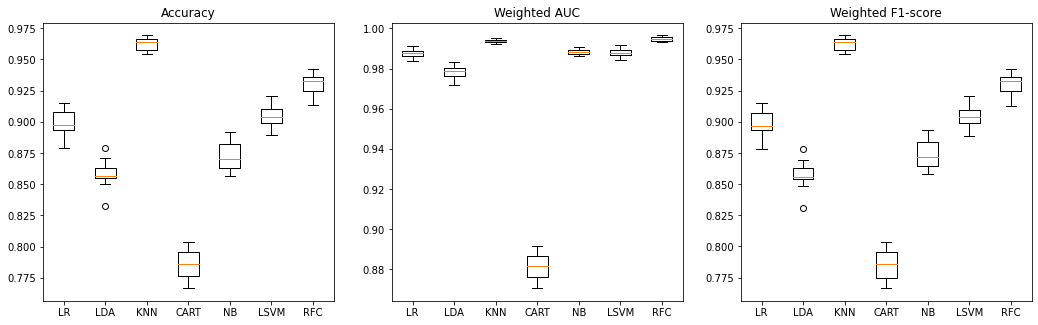

In [103]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3*15/2.54, 13/2.54))
for ax, scoring, results in zip(axs, ['Accuracy', 'Weighted AUC', 'Weighted F1-score'], [accuracies, aucs, f1_scores]):
    ax.boxplot([*results]) # convert to a list of numpy.array
    ax.set_title(scoring)
    ax.set_xticklabels(names)
fig.savefig(os.path.join(plots_directory, "algorithms_comparison_1.pdf"))

Remove LDA, CART and NB to clean the plot above.

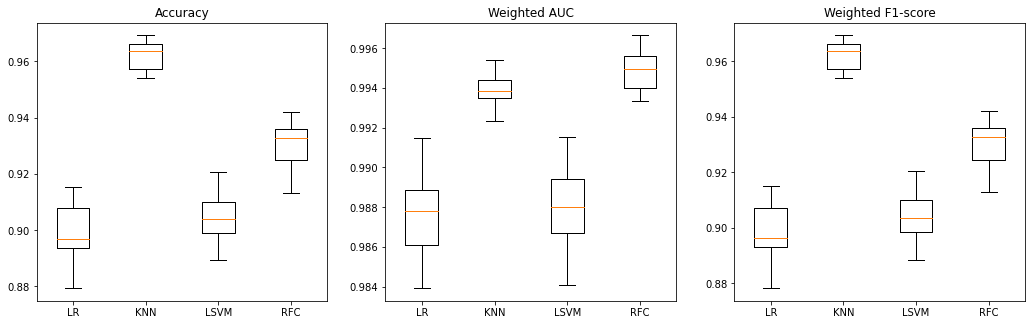

In [104]:
to_keep = (names != 'LDA') & (names != 'CART') & (names != 'NB')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3*15/2.54, 13/2.54))
for ax, scoring, results in zip(axs, ['Accuracy', 'Weighted AUC', 'Weighted F1-score'], [accuracies, aucs, f1_scores]):
    ax.boxplot([*results[to_keep]]) # convert to a list of numpy.array
    ax.set_title(scoring)
    ax.set_xticklabels(names[to_keep])
fig.savefig(os.path.join(plots_directory, "algorithms_comparison_2.pdf"))

Let's plot the confusion matrices.

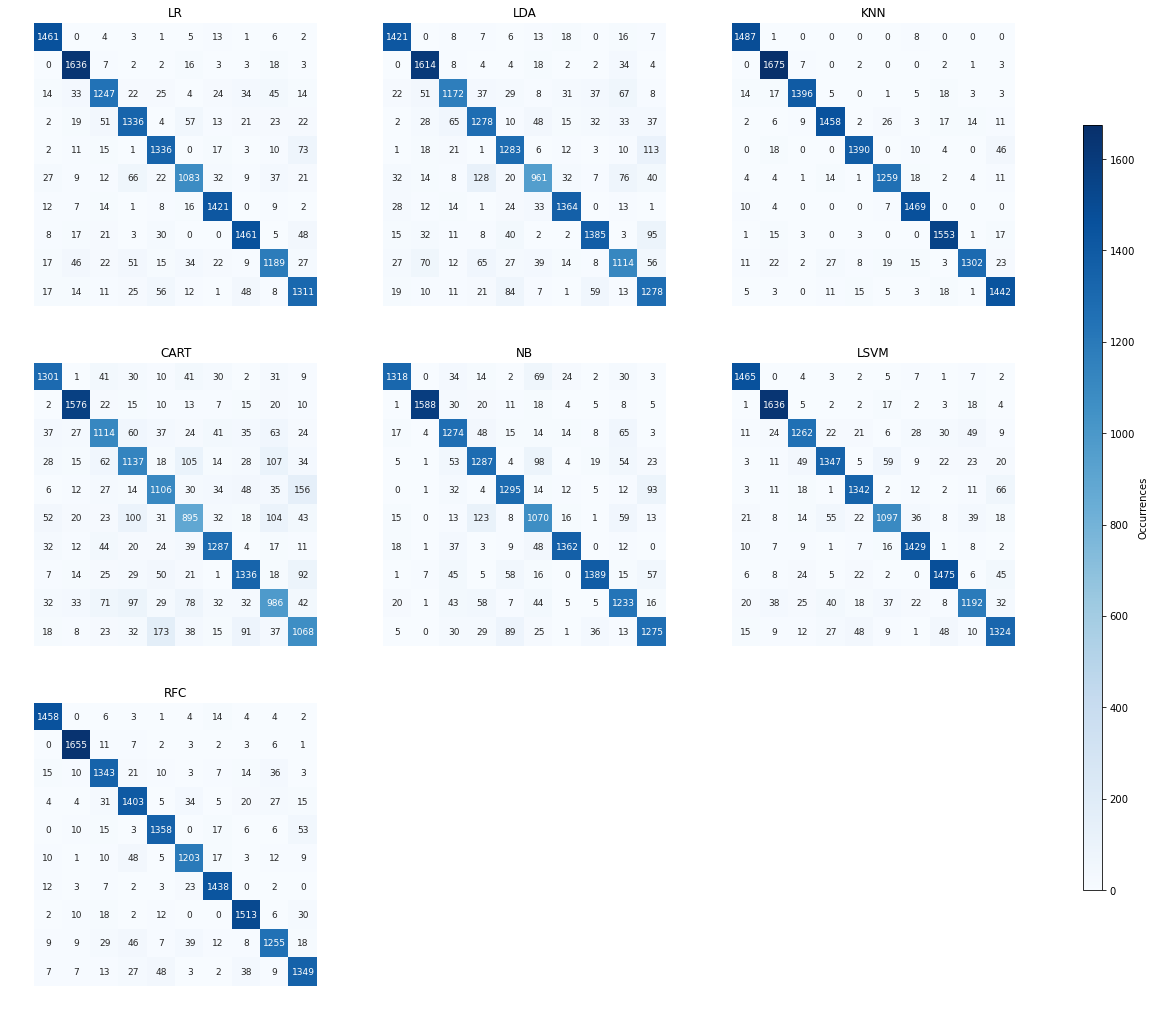

In [105]:
w_cbar = 0.7 # cm
main_dimension = 15 # cm
ncols = 3
nrows = np.ceil(len(models) / 3).astype(np.int)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*main_dimension/2.54, nrows*main_dimension/2.54))
axs.flatten()[0].set_aspect("equal", share=True)
for ax in axs.flatten():
    ax.set_frame_on(False)
    ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# draw a big invisible axes to insert common colormap
big_ax = fig.add_subplot(111, frameon=False)
big_ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
v_min, v_max = 0, np.max(confusion_matrices)
cmap = "Blues"
scalar_mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=v_min, vmax=v_max))
# set a constant width of colorbar: modify aspect parameter on the basis of the new height of colorbar
transformation = fig.transFigure + fig.dpi_scale_trans.inverted()
h_cbar_fig = 0.6
h_cbar = transformation.transform((0., h_cbar_fig))[1]
# draw the colorbar
cbar = fig.colorbar(scalar_mappable, ax=big_ax, aspect=h_cbar*2.54/w_cbar)
cbar.ax.set_position([0.95, 0.2, 0.1, h_cbar_fig])
cbar.ax.set_ylabel("Occurrences")
# draw the confusion matrices
for ax, name, cm in zip(axs.flatten(), names, confusion_matrices): # if there are less names than axes, it is truncated automatically
    ax.set_title(name)
    sns.heatmap(cm, ax=ax, annot=True, annot_kws={'fontsize': 9}, cmap=cmap, fmt="d", vmin=v_min, vmax=v_max, cbar=False)
fig.savefig(os.path.join(plots_directory, "confusion_matrices.pdf"))

## Algorithms fine-tuning
On the basis of these results, we choose to fine-tune the following models:
* KNN;
* RFC.

We choose 3 folds in this phase.

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint
set_option('precision', 5)
num_folds_ft = 3

Define a function to save the models at the end.

In [22]:
def save_model(model, name, directory):
    dump(model, os.path.join(directory, "{}.joblib".format(name)))

### $k$-Nearest Neighbour
The model parameters are the followings:

In [28]:
print(", ".join(models['KNN'].get_params().keys()))

estimator__algorithm, estimator__leaf_size, estimator__metric, estimator__metric_params, estimator__n_jobs, estimator__n_neighbors, estimator__p, estimator__weights, estimator, n_jobs


First perform a randomised search in order to find more or less where to look deeper.

In [30]:
kfold = KFold(n_splits=num_folds_ft, random_state=seed, shuffle=True)
param_grid = {
    'estimator__n_neighbors': randint(low=1, high=31),
    'estimator__leaf_size': randint(low=1, high=51),
    'estimator__p': randint(low=1, high=3)
}
clf = RandomizedSearchCV(models['KNN'], param_distributions=param_grid, n_iter=100, cv=kfold, scoring='accuracy', n_jobs=-1, random_state=seed)
clf.fit(x_train, y_train)
best_params = {}
best_params.update(clf.best_params_)
best_params.update({'accuracy': clf.best_score_})
pd.DataFrame({'Best fit': best_params}).T

,accuracy,estimator__leaf_size,estimator__n_neighbors,estimator__p
Best fit,0.96007,36.0,1.0,2.0


Now perform a grid search around the found points (here I increase also the number of folds, so the training examples will be more).

In [112]:
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
param_grid = {
    'estimator__n_neighbors': [1, 3, 5, 7, 9],
    'estimator__leaf_size': [30, 32, 34, 36, 38, 40, 42],
}
clf = GridSearchCV(models['KNN'], param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
clf.fit(x_train, y_train)
best_params = {}
best_params.update(clf.best_params_)
best_params.update({'accuracy': clf.best_score_})
pd.DataFrame({'Best fit': best_params}).T

,accuracy,estimator__leaf_size,estimator__n_neighbors
Best fit,0.96347,30.0,1.0


In [113]:
save_model(model=clf.best_estimator_, name='KNN', directory=models_directory)

### Random Forest Classifier
The model parameters are the followings.

In [132]:
print(", ".join(models['RFC'].get_params().keys()))

bootstrap, ccp_alpha, class_weight, criterion, max_depth, max_features, max_leaf_nodes, max_samples, min_impurity_decrease, min_impurity_split, min_samples_leaf, min_samples_split, min_weight_fraction_leaf, n_estimators, n_jobs, oob_score, random_state, verbose, warm_start


First perform a randomised search in order to find more or less where to look deeper.

In [25]:
kfold = KFold(n_splits=num_folds_ft, random_state=seed, shuffle=True)
param_grid = {
    'n_estimators': randint(low=10, high=351),
    'max_depth': randint(low=1, high=51),
    'min_samples_split': randint(low=2, high=10),
}
clf = RandomizedSearchCV(models['RFC'], param_distributions=param_grid, n_iter=300, cv=kfold, scoring='accuracy', n_jobs=-1, random_state=seed)
clf.fit(x_train, y_train)
best_params = {}
best_params.update(clf.best_params_)
best_params.update({'accuracy': clf.best_score_})
pd.DataFrame({'Best fit': best_params}).T

,accuracy,max_depth,min_samples_split,n_estimators
Best fit,0.93133,29.0,3.0,301.0


Now perform a grid search around the found points.

In [26]:
kfold = KFold(n_splits=num_folds_ft, random_state=seed, shuffle=True)
param_grid = {
    'n_estimators': [296, 301, 306],
    'max_depth': [24, 29, 34, None],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 5, 10, 50]
}
clf = GridSearchCV(models['RFC'], param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
clf.fit(x_train, y_train)
best_params = {}
best_params.update(clf.best_params_)
best_params.update({'accuracy': clf.best_score_})
pd.DataFrame({'Best fit': best_params}).T

,accuracy,max_depth,min_samples_leaf,min_samples_split,n_estimators
Best fit,0.9318,34.0,1.0,2.0,301.0


In [27]:
save_model(model=clf.best_estimator_, name='RFC', directory=models_directory)

## Final results on test set
Define a function to load the saved models.

In [114]:
def load_model(name, directory):
    return load(os.path.join(directory, "{}.joblib".format(name)))

We will use accuracy to assess the models.

In [115]:
from sklearn.metrics import accuracy_score
def assess_model(model):
    y_predicted = model.predict(x_test)
    return accuracy_score(y_true=y_test, y_pred=y_predicted)

### $k$-Nearest Neighbour

In [116]:
model_knn = load_model(name='KNN', directory=models_directory)

In [121]:
accuracy_knn = assess_model(model=model_knn)
print("The accuracy of the model\n{0:s}\non the test set is: {1:.2%}".format(str(model_knn), accuracy_knn))

The accuracy of the model
OneVsRestClassifier(estimator=KNeighborsClassifier(n_neighbors=1), n_jobs=8)
on the test set is: 93.60%


### Random Forest Classifier

In [122]:
model_rfc = load_model(name='RFC', directory=models_directory)

In [123]:
accuracy_rfc = assess_model(model=model_rfc)
print("The accuracy of the model\n{0:s}\non the test set is: {1:.2%}".format(str(model_rfc), accuracy_rfc))

The accuracy of the model
RandomForestClassifier(max_depth=34, n_estimators=301)
on the test set is: 90.80%
